In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.3.0+cu121
2.3.0+cu121
cpu


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

sound_voice = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 136MB/s]


# Using Connectionist Temporal Classification (CTC) to classify characters

Basic architectures for characters classification use an encoder-only transformer to read the input sequence (the audio waveform) and encode it into a sequence of hidden-states, i.e.,embeddings.
However, alignment is lost...

In Wave2Vec (one of the existing models, read https://arxiv.org/pdf/2006.11477.pdf) first CNN layers downsample the input to produce a sequence of 50 hidden-states. Each hidden-state corresponds to about 25ms (with a small overlapping between consecutive embeddings - about 5ms).
After this the transformer encoder receives the 50 hidden-states and produces an encoding of such states into 50 embeddings of dimensionality 768.
Finally, we pass these embeddings to a linear layer to map them into the possible tokens of a very small (typically a 32 items or less) vocabulary (output is a (50,32) tensor).
For each token the corresponding input is 20ms (plus 5ms overlapping) of audio, hence each of them correspond to roughly a character.
However, we predict 50 characters in (50*20=1000ms) one second audio. So surely if a charater is pronounced in more than 20ms we will have duplicates.
CTC algorithm introduced two special characters the "black" (_) and the space (|) to easy word classification.


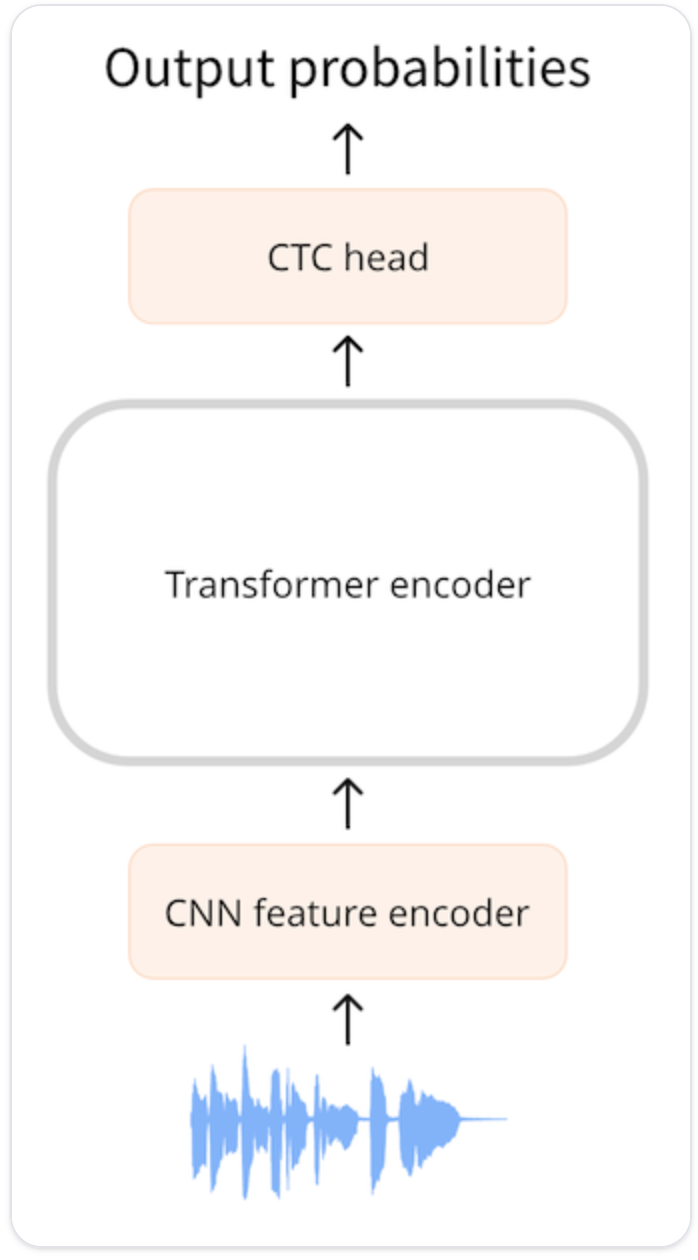

In torchaudio, we have pre-trained versions of many CTC models. A pre-trained WAV2VEC 2.0 is also available.
Let's load it.

In torchaudio we have trained models embedded into objects including additional information, such as the "sample rate", the "labels" (i.e., the dictionaries tokens) and so so forth - read https://pytorch.org/audio/stable/generated/torchaudio.pipelines.Wav2Vec2ASRBundle.html#torchaudio.pipelines.Wav2Vec2ASRBundle.

The model has been trained with a specific audio sample rate, which is avaiable in the object.
Considered labels are 29!

In [3]:
ctc_preTrained_object = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("This is the model sample rate:", ctc_preTrained_object.sample_rate)

print("These are the considered tokens:", ctc_preTrained_object.get_labels())

This is the model sample rate: 16000
These are the considered tokens: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
model = ctc_preTrained_object.get_model().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:03<00:00, 111MB/s]


This object contains also the trained model, let's load it into our GPU.

Let's now import our previously developed audio manipulation functions.
Remember: we sent the model to our device (GPU), so also the input data must be loaded there.
Also, make sure to resample input to the model sampling rate - the model expects a (1,seconds*16000) tensor.

In [6]:
import audio_support_functions as myFunc

waveform, sample_rate = torchaudio.load(sound_voice)
waveform = waveform.to(device) # send data to the device!

myFunc.play_audio(waveform.cpu(), sample_rate) #check the sample audio

print(sample_rate)

if sample_rate!=ctc_preTrained_object.sample_rate:
  waveform = torchaudio.functional.resample(waveform, sample_rate, ctc_preTrained_object.sample_rate)


#waveform = waveform if sample_rate==ctc_preTrained_object.sample_rate else torchaudio.functional.resample(waveform, sample_rate, ctc_preTrained_object.sample_rate)


16000


In [7]:
waveform.shape

torch.Size([1, 54400])

In [8]:
with torch.inference_mode(): #this is to disable grad reasonings and improve performance
    pred_tokens, _ = model(waveform)
print(pred_tokens.size())
#we have 169 identified characters each associated with a vector with 29 values (logits)
#(i.e., the strenght of believing that a word is one of the 29 tokens of the dictionary)

torch.Size([1, 169, 29])


In [9]:
class GreedyAlgorithmDecoder(torch.nn.Module):
    def __init__(self, labels, blank_position=0): #we can specify the position of blank value in the label list - in this case pos 0
        super().__init__()
        self.labels = labels
        self.blank = blank_position

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)  # grab the highest logit for each sequence in the tensor
        #print(indices.shape)
        #if a character is spelled for more than 20ms
        #we will have consecutive duplicates, so we need to remove them
        indices = torch.unique_consecutive(indices)
        indices = [i for i in indices if i != self.blank] #now remove blank character - remove index 0
        return "".join([self.labels[i] for i in indices]) #grab token from the dictionary using indexes

In [10]:
greedy_CTC_decoder = GreedyAlgorithmDecoder(labels=ctc_preTrained_object.get_labels())
transcript = greedy_CTC_decoder(pred_tokens[0]) #it's a tensor with one channel and 169 words mapped to 29 tokens

In [11]:
print(transcript)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


# Advanced!

Beam Search is a more advanced algorithm to identify the best sequences according to the model emissions.
Basic idea is that it explores multiple possible sequences of tokens and selects the most likely ones based on a scoring function. Beam search is particularly useful in decoding the output of models trained with sequence generation techniques like recurrent neural networks (RNNs) or transformers.

Basic strategy is as follows:

1. The algorithm initializes with a list of beams, each containing a sequence of tokens and its corresponding state (whether they are conclusive or not). For starters, we will have only initial tokens.

3. In each iteration, the algorithm expands each beam by generating the next set of tokens using the model. It then selects the top k (where k is the maximum size for a beam at at single step) tokens as candidates for each beam.

4. For each candidate token, the algorithm appends it to the beam's sequence, updates the beam's state based on the candidate token, and adds the updated beam to a new list of beams.

5. Once all beams are processed, the algorithm sorts the new beams by their scores (e.g., log probabilities or other evaluation) and selects the top beam_width beams to continue the search.

6. The process repeats until the maximum sequence length is reached or no more sequences are active (i.e., all beams are completed or stopped).

Beam search efficiently explores the search space by maintaining a limited number of active sequences (beams) at each step, thereby balancing between exploration and exploitation. The beam_width parameter controls the trade-off between exploration (higher values) and exploitation (lower values). Larger beam widths increase the computational cost but may yield better results by exploring more diverse sequences.

Example:

Vocabulary: ['a', 'b', 'c']

And let's perform beam search to generate sequences of length 2 with a beam width of 2.

Initialization: At the beginning, the token state is simply the start token, indicating the start of the sequence.

Token state: [\<start\>] ... any symbol here

Step 1:

Beam 1: [\<start\>, 'a'], Score: 1
Beam 2: [\<start\>, 'b'], Score: 1

Token states for each beam:

Beam 1: Token state: [\<start\>] → [\<start\>, 'a']

Beam 2: Token state: [\<start\>] → [\<start\>, 'b']


Step 2:

Beam 1: [\<start\>, 'a', 'a'], Score: 2

Beam 1: [\<start\>, 'a', 'b'], Score: 2

Beam 2: [\<start\>, 'b', 'a'], Score: 2

Beam 2: [\<start\>, 'b', 'b'], Score: 2

Token states for each beam:

Beam 1: Token state: [\<start\>, 'a'] → [\<start\>, 'a', 'a'] and [\<start\>, 'a'] → [\<start\>, 'a', 'b']

Beam 2: Token state: [\<start\>, 'b'] → [\<start\>, 'b', 'a'] and [\<start\>, 'b'] → [\<start\>, 'b', 'b']

At this stage, the sequences are completed, and we stop the search.

In [12]:
!pip install flashlight-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00


In [13]:
from torchaudio.models.decoder import download_pretrained_files

files = download_pretrained_files("librispeech-4-gram")

print(files)
print(files.tokens)

f = open(files.tokens, "r")

print(f.read())


100%|██████████| 4.97M/4.97M [00:00<00:00, 95.5MB/s]
100%|██████████| 57.0/57.0 [00:00<00:00, 62.1kB/s]
100%|██████████| 2.91G/2.91G [00:19<00:00, 157MB/s]

PretrainedFiles(lexicon='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lexicon.txt', tokens='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt', lm='/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin')
/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/tokens.txt
-
|
e
t
a
o
n
i
h
s
r
d
l
u
m
w
c
f
g
y
p
b
v
k
'
x
j
q
z


The lexicon is a mapping from words to their corresponding tokens sequence, and is used to restrict the search space of the decoder to only words from the lexicon. The expected format of the lexicon file is a line per word, with a word followed by its space-split tokens.

In [14]:
f = open(files.lexicon, "r")
print(f.readline())
print(f.readline())
print(f.readline())
print(f.readline())

a	a |

a''s	a ' ' s |

a'body	a ' b o d y |

a'court	a ' c o u r t |



In [15]:
files.lm

'/root/.cache/torch/hub/torchaudio/decoder-assets/librispeech-4-gram/lm.bin'

Language model can be used to improve ASR performance by estimating a probability of having a particular sequence as output.
In files we have a 4-gram KenLM trained using LibriSpeech.

https://kheafield.com/code/kenlm/

From the flashlight library: https://arxiv.org/pdf/2201.12465.pdf

In [16]:
from torchaudio.models.decoder import ctc_decoder


beam_search_decoder = ctc_decoder(
    lexicon=files.lexicon,
    tokens=files.tokens,
    lm=files.lm,
    nbest=3, #how many sequences we want to return
    beam_size=1500
)

In [17]:
import torch
import torchaudio



# Convert pred_tokens to CPU
pred_tokens = pred_tokens.to('cpu')


# Perform beam search decoding
beam_search_result = beam_search_decoder(pred_tokens)
print(beam_search_result)

# Get the transcript from the beam search result
beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()

# Define the real transcript
real_transcript = "i had that curiosity beside me at this moment"
real_transcript = real_transcript.split()

# Calculate the edit distance
beam_search_error = torchaudio.functional.edit_distance(
    real_transcript, beam_search_result[0][0].words
) / len(real_transcript)

# Print the results
print(f"Transcript: {beam_search_transcript}")
print(f"Error: {beam_search_error}")

# Example output for visualization
print("Beam search result structure:", beam_search_result)


[[CTCHypothesis(tokens=tensor([ 1,  7,  1,  8,  4, 11,  1,  3,  8,  4,  3,  1, 16, 13, 10,  7,  5,  9,
         7,  3, 19,  1, 21,  2,  9,  7, 11,  2,  1, 14,  2,  1,  4,  3,  1,  3,
         8,  7,  9,  1, 14,  5, 14,  2,  6,  3,  1,  1]), words=['i', 'had', 'that', 'curiosity', 'beside', 'me', 'at', 'this', 'moment'], score=2489.610311627388, timesteps=tensor([  0,  31,  34,  37,  39,  41,  43,  45,  47,  49,  50,  52,  56,  61,
         63,  67,  74,  79,  83,  86,  89,  91,  95,  98, 102, 109, 111, 113,
        115, 118, 120, 123, 126, 127, 128, 130, 132, 134, 136, 138, 142, 146,
        149, 152, 153, 154, 156, 170], dtype=torch.int32)), CTCHypothesis(tokens=tensor([ 1,  7,  1,  8,  4, 22,  2,  1,  3,  8,  4,  3,  1, 16, 13, 10,  7,  5,
         9,  7,  3, 19,  1, 21,  2,  9,  7, 11,  2,  1, 14,  2,  1,  4,  3,  1,
         3,  8,  7,  9,  1, 14,  5, 14,  2,  6,  3,  1,  1]), words=['i', 'have', 'that', 'curiosity', 'beside', 'me', 'at', 'this', 'moment'], score=2483.0522965192795

# Report Suggestions:



1. Understand the Wave2Vec 2.0 model and discuss about the solution.
2. Improve greedy algorithm performance (can we boost it? How?)
3. Work with the BeamSearch algorithm and try different configuration, what can you see?

2. Improve Greedy Algorithm Performance


In [26]:
import torch
import torchaudio

# Class definition for the improved greedy algorithm decoder with post-processing
class ImprovedGreedyAlgorithmDecoder(torch.nn.Module):
    def __init__(self, labels, blank_position=0, temperature=1.0):
        super().__init__()
        self.labels = labels
        self.blank = blank_position
        self.temperature = temperature

    def forward(self, emission: torch.Tensor) -> str:
        # Apply temperature scaling
        emission = emission / self.temperature
        # Grab the highest logit for each sequence in the tensor
        indices = torch.argmax(emission, dim=-1)
        # Remove consecutive duplicates
        indices = torch.unique_consecutive(indices)
        # Remove blank characters
        indices = [i for i in indices if i != self.blank]
        # Convert indices to string
        transcript = "".join([self.labels[i] for i in indices])
        # Post-process the transcript
        transcript = self.post_process_transcript(transcript)
        return transcript

    def post_process_transcript(self, transcript):
        # Remove separator characters and join words with spaces
        transcript = transcript.replace('|', ' ')
        # Additional corrections
        corrections = {
            "hte": "the",
            "teh": "the",
            # Add more common mistakes and corrections here
        }
        words = transcript.split()
        corrected_words = [corrections.get(word, word) for word in words]
        return " ".join(corrected_words)

# Using a lower temperature to make the model more confident and post-processing
improved_greedy_decoder = ImprovedGreedyAlgorithmDecoder(labels=ctc_preTrained_object.get_labels(), temperature=0.8)

# Perform inference with improved greedy decoder
with torch.inference_mode():
    pred_tokens, _ = model(waveform)

improved_transcript = improved_greedy_decoder(pred_tokens[0])
print(f"Improved greedy decoder transcript: {improved_transcript}")



# Perform inference with improved greedy decoder
improved_transcript = improved_greedy_decoder(pred_tokens[0])
print(f"Improved greedy decoder transcript: {improved_transcript}")

# Example output for visualization
print("Transcript after post-processing:", improved_transcript)


Improved greedy decoder transcript: I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT
Improved greedy decoder transcript: I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT
Transcript after post-processing: I HAD THAT CURIOSITY BESIDE ME AT THIS MOMENT


3. Work with the BeamSearch Algorithm


In [36]:

# Function to setup beam search decoder
def setup_decoder(nbest=3, beam_size=1500):
    files = download_pretrained_files("librispeech-4-gram")
    beam_search_decoder = ctc_decoder(
        lexicon=files.lexicon,
        tokens=files.tokens,
        lm=files.lm,
        nbest=nbest,
        beam_size=beam_size
    )
    return beam_search_decoder

# Function to perform beam search decoding
def perform_beam_search(decoder, pred_tokens):
    pred_tokens = pred_tokens.to('cpu')
    beam_search_result = decoder(pred_tokens)
    beam_search_transcript = " ".join(beam_search_result[0][0].words).strip()
    return beam_search_transcript, beam_search_result

# Function to calculate edit distance
def calculate_edit_distance(real_transcript, predicted_transcript):
    real_transcript = real_transcript.split()
    predicted_transcript = predicted_transcript.split()
    return torchaudio.functional.edit_distance(real_transcript, predicted_transcript) / len(real_transcript)

# Real transcript for comparison
real_transcript = "i had that curiosity beside me at this moment"


Configuration 1: Default settings


In [37]:
# Setup decoder with default settings
beam_search_decoder_default = setup_decoder(nbest=3, beam_size=1500)

# Perform beam search decoding
beam_search_transcript_default, beam_search_result_default = perform_beam_search(beam_search_decoder_default, pred_tokens)
beam_search_error_default = calculate_edit_distance(real_transcript, beam_search_transcript_default)

print(f"Default Configuration:")
print(f"Transcript: {beam_search_transcript_default}")
print(f"Error: {beam_search_error_default}\n")


Default Configuration:
Transcript: i had that curiosity beside me at this moment
Error: 0.0



Configuration 2: Increased beam_size


In [38]:
# Setup decoder with larger beam size
beam_search_decoder_large_beam = setup_decoder(nbest=3, beam_size=2000)

# Perform beam search decoding
beam_search_transcript_large_beam, beam_search_result_large_beam = perform_beam_search(beam_search_decoder_large_beam, pred_tokens)
beam_search_error_large_beam = calculate_edit_distance(real_transcript, beam_search_transcript_large_beam)

print(f"Larger Beam Size Configuration:")
print(f"Transcript: {beam_search_transcript_large_beam}")
print(f"Error: {beam_search_error_large_beam}\n")


Larger Beam Size Configuration:
Transcript: i had that curiosity beside me at this moment
Error: 0.0



Configuration 4: Increased beam_size and nbest


In [39]:
# Setup decoder with larger nbest
beam_search_decoder_nbest = setup_decoder(nbest=5, beam_size=1500)

# Perform beam search decoding
beam_search_transcript_nbest, beam_search_result_nbest = perform_beam_search(beam_search_decoder_nbest, pred_tokens)
beam_search_error_nbest = calculate_edit_distance(real_transcript, beam_search_transcript_nbest)

print(f"Larger Nbest Configuration:")
print(f"Transcript: {beam_search_transcript_nbest}")
print(f"Error: {beam_search_error_nbest}\n")


Larger Nbest Configuration:
Transcript: i had that curiosity beside me at this moment
Error: 0.0



Step 3: Compare the Results


In [42]:
print("Comparison of Configurations:")
print(f"Default beam size error: {beam_search_error_default}")
print(f"Larger beam size error: {beam_search_error_large_beam}")
print(f"Larger nbest error: {beam_search_error_nbest}")


Comparison of Configurations:
Default beam size error: 0.0
Larger beam size error: 0.0
Larger nbest error: 0.0
